# stLearn Analysis approaches
This notebook outlines a pipeline for the loading and analysis of Spatial Resolved Transcriptomics data using in-situ sequencing techniques such as 10xVisium. The data analysed with consist of both 10xVisium for multi-cellular splot resolution data along with Single cell resolution sequencing data from 


*Note on st learn, requirements as listed by the package are not enough to ensure that it runs correctly. I had to alter the Kmeans function to call pass algorithm as 'lloyd' rather than 'auto'*

## Data Loading and Preparation

In [2]:
#IMPORTS 
import stlearn as st
from pathlib import Path
st.settings.set_figure_params(dpi=120)

In [3]:
WD_PATH = "/mnt/c/Users/rdbra/Documents/honours_2024/code_base/ST_honours_2024/basicAnalysis/"
BASE_PATH = Path(WD_PATH+"data/vis_mouse_cor")

#Spot tile is the result of image pre-processing
TILE_PATH = Path("/tmp/tiles")
TILE_PATH.mkdir(parents=True, exist_ok=True)

# output path
OUT_PATH = Path(WD_PATH+"sequencedSTanalysis/stLearnPlot/")
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
data = st.Read10X(BASE_PATH)

/home/duncanbrady/honours24/codebase/ST_Honours_2024/.stlearn/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/duncanbrady/honours24/codebase/ST_Honours_2024/.stlearn/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
st.pp.filter_genes(data, min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [6]:
st.pp.tiling(data, TILE_PATH)
st.pp.extract_feature(data)

Tiling image:   0%|           [ time left: ? ]

Tiling image: 100%|██████████ [ time left: 00:00 ]
2024-03-15 08:57:36.580629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 08:57:36.863372: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-15 08:57:36.923092: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-15 08:57:36.923111: I tensorflow/compiler/xla/stream_

The morphology feature is added to adata.obsm['X_morphology']!


## Clustering

In [7]:
st.em.run_pca(data, n_comps=50)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [8]:
data_SME = data.copy()
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.pp.scale(data_SME)
st.em.run_pca(data_SME, n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
Scale step is finished in adata.X
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Applying Kmeans cluster ...
Kmeans cluster is done! The labels are stored in adata.obs["kmeans"]


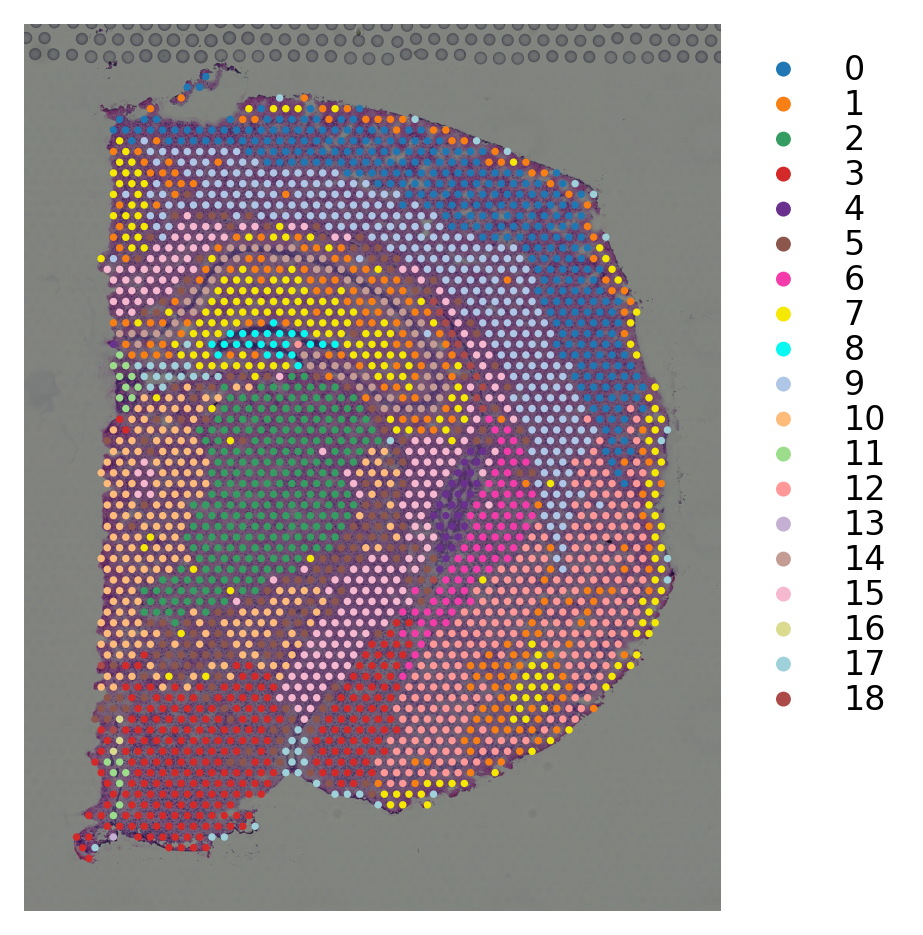

In [9]:
st.tl.clustering.kmeans(data_SME,n_clusters=19, use_data="X_pca", key_added="X_pca_kmeans")
st.pl.cluster_plot(data_SME, use_label="X_pca_kmeans")

Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 
Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


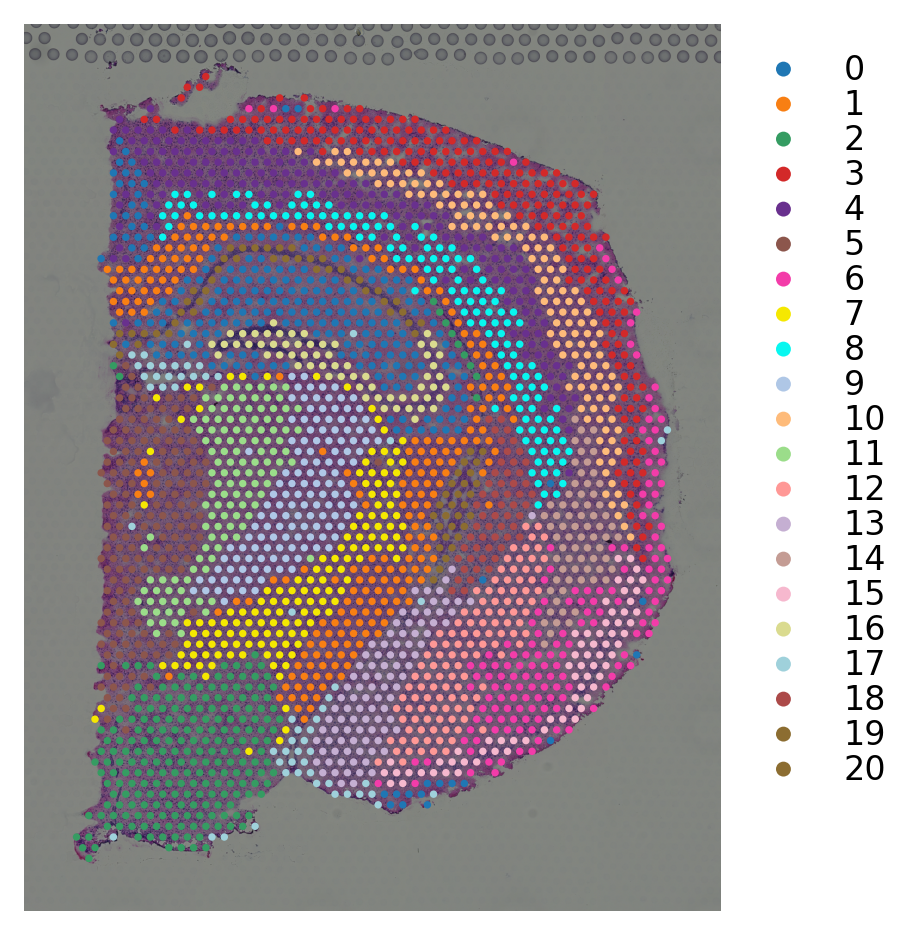

In [10]:
# louvain clustering on stSME normalised data
st.pp.neighbors(data_SME,n_neighbors=17,use_rep='X_pca')
st.tl.clustering.louvain(data_SME, resolution=1.19)
st.pl.cluster_plot(data_SME,use_label="louvain")

## Normalisation

In [11]:
# Duplicate data without SME normalisation
data_normal = data.copy()

# Create SME normalised data set
data_SME = data.copy()
# apply stSME to normalise log transformed data
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.em.run_pca(data_SME,n_comps=50)

Adjusting data: 100%|██████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


Text(0.5, 1.0, 'Gene: Lhfpl1 (SME)')

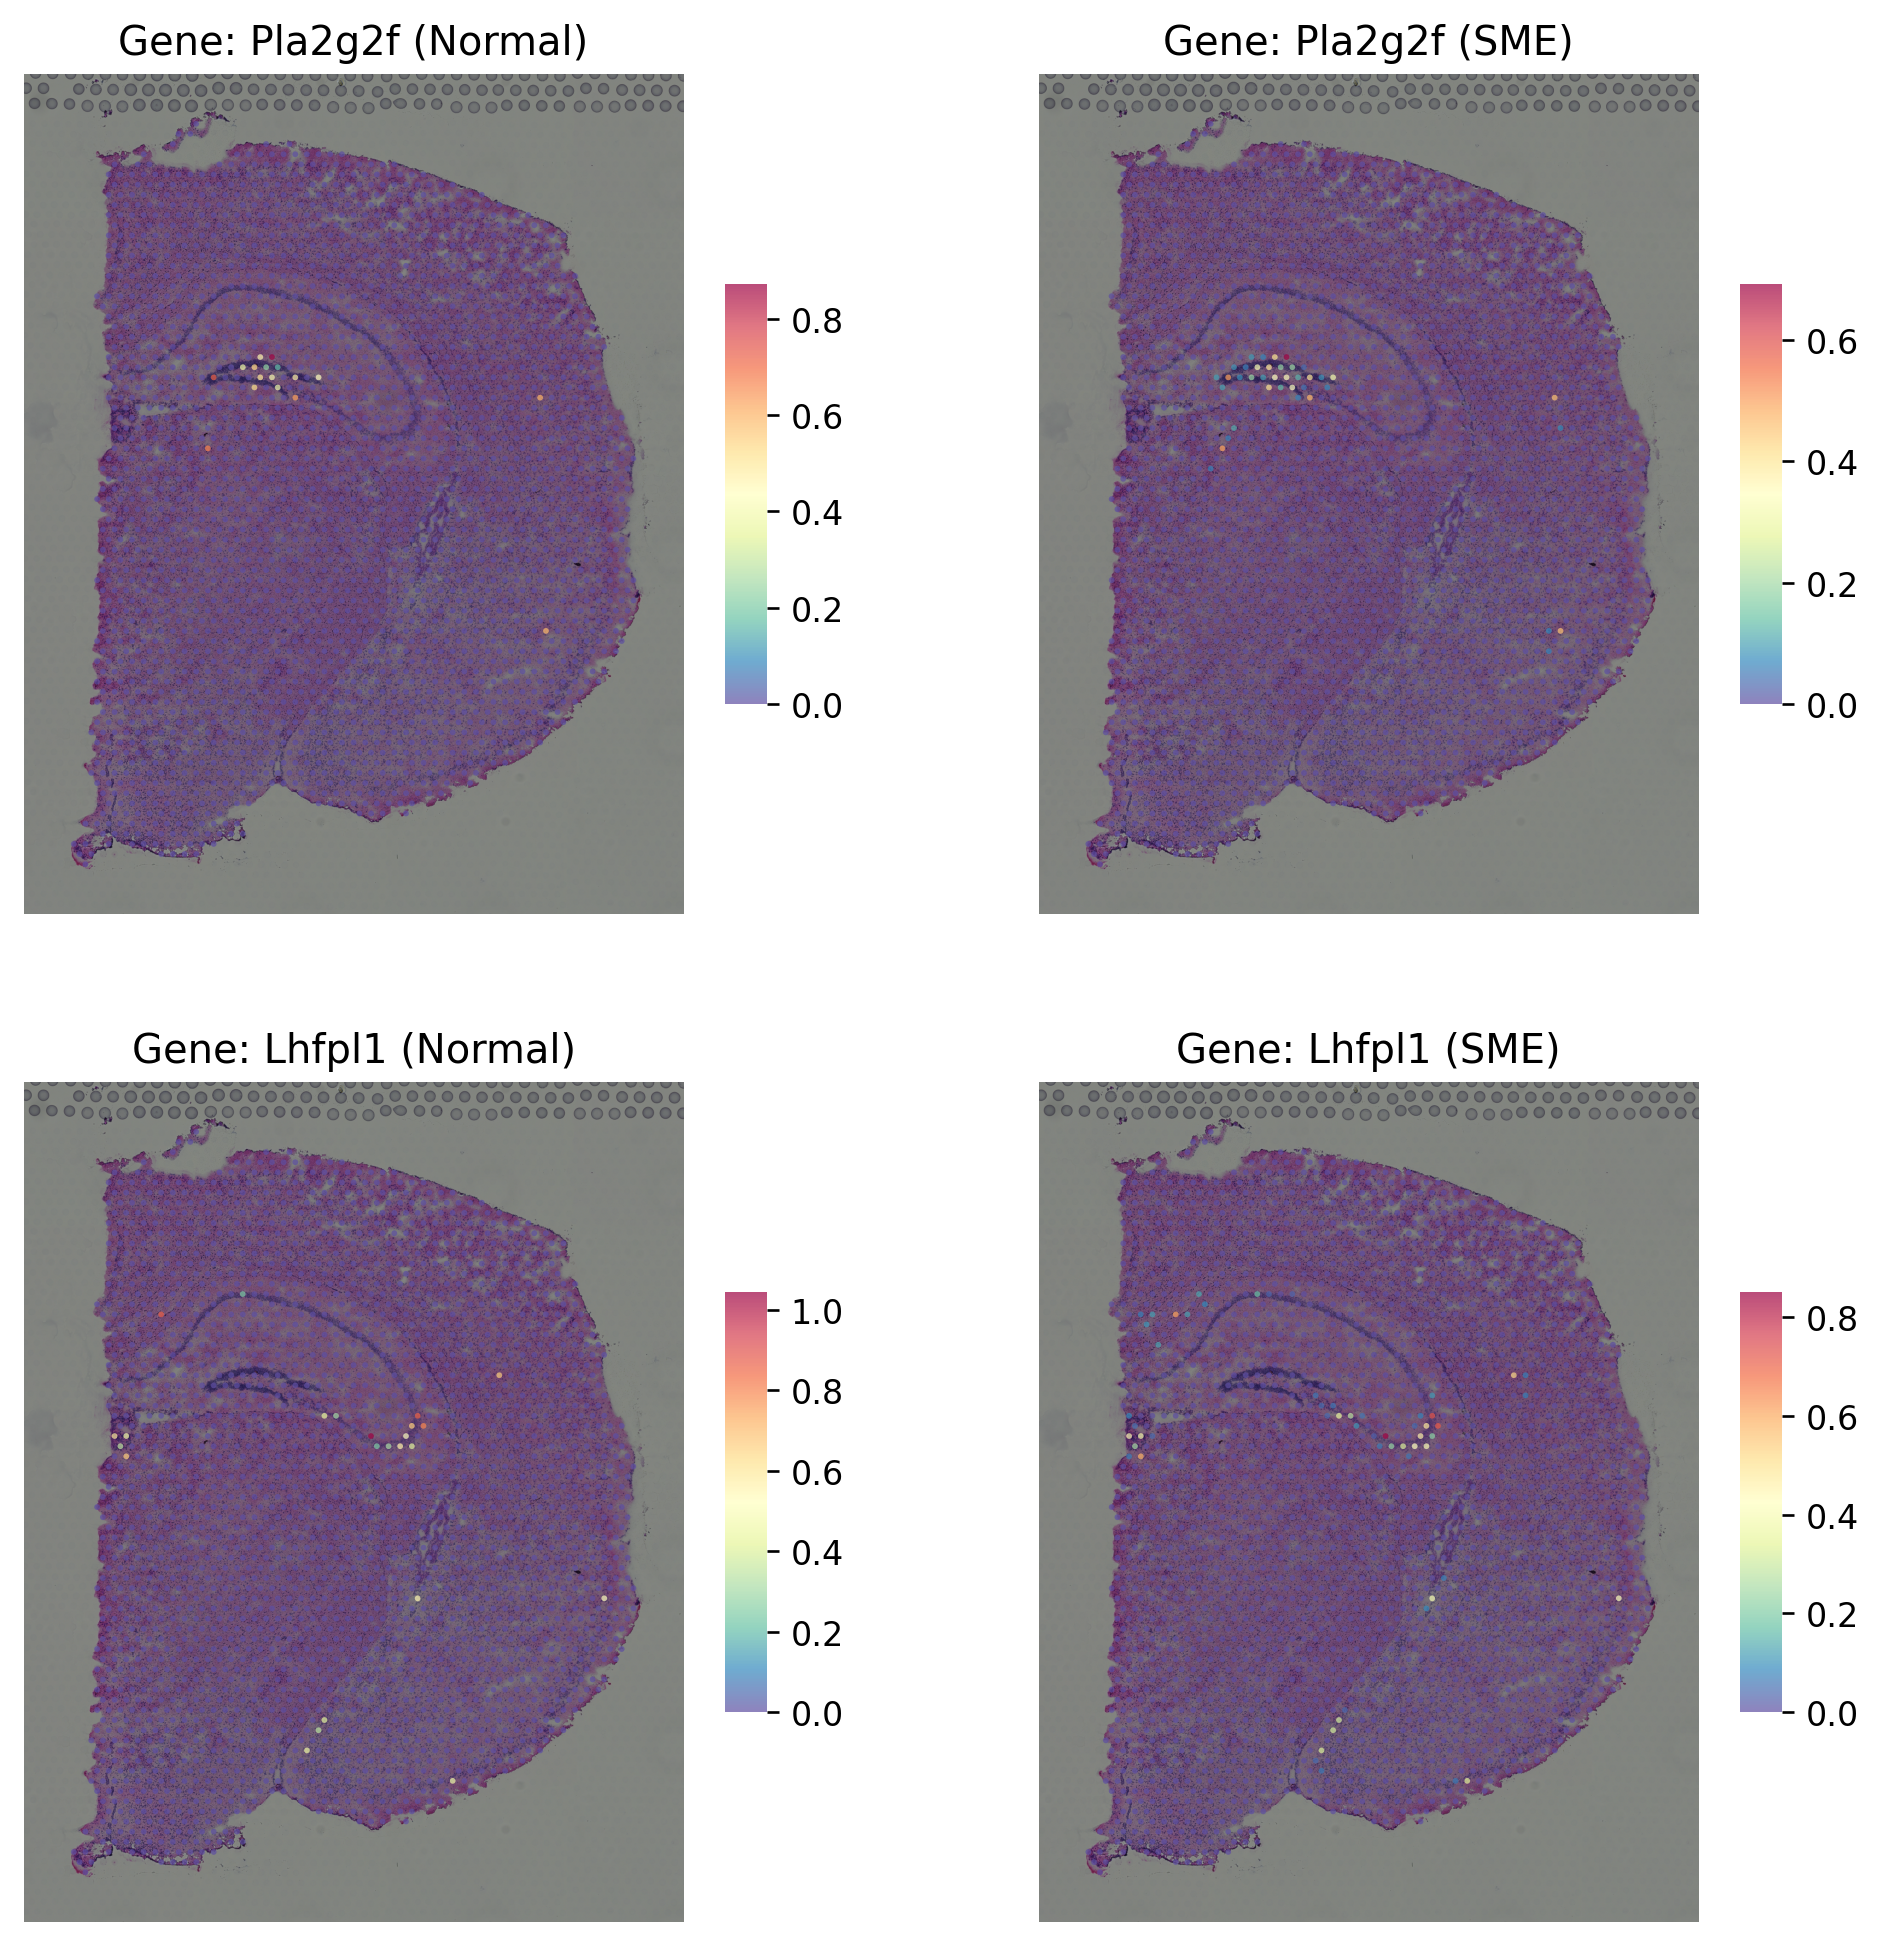

In [12]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first gene
i = "Pla2g2f"
st.pl.gene_plot(data_normal, gene_symbols=i, size=3, figsize=(10,10), ax=axes[0, 0])
st.pl.gene_plot(data_SME, gene_symbols=i, size=3,figsize=(10,10),ax=axes[0, 1])
axes[0, 0].set_title(f"Gene: {i} (Normal)")
axes[0, 1].set_title(f"Gene: {i} (SME)")


# Plot the second gene
i = "Lhfpl1"
st.pl.gene_plot(data_normal, gene_symbols=i, size=3, figsize=(10,10), ax=axes[1,0])
st.pl.gene_plot(data_SME, gene_symbols=i, size=3, figsize=(10,10),ax=axes[1,1])
axes[1, 0].set_title(f"Gene: {i} (Normal)")
axes[1, 1].set_title(f"Gene: {i} (SME)")




## Cell Interaction Analysis

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
data_path = "/mnt/c/Users/rdbra/Documents/honours_2024/code_base/ST_Honours_2024/basicAnalysis/data/V1_Breast_Cancer_Block_A_Section_1"


In [15]:
data = st.Read10X(data_path)
data.var_names_make_unique()
st.add.image(adata=data,
             imgpath=data_path+"/spatial/tissue_hires_image.png",
             library_id="V1_Breast_Cancer_Block_A_Section_1", visium=True)

# Basic normalisation #
st.pp.filter_genes(data, min_cells=3)
st.pp.normalize_total(data) # NOTE: no log1p



/home/duncanbrady/honours24/codebase/ST_Honours_2024/.stlearn/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/duncanbrady/honours24/codebase/ST_Honours_2024/.stlearn/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added tissue image to the object!
Normalization step is finished in adata.X


In [16]:
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

st.tl.cci.run(data, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=None, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=100, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=4, # Number of CPUs for parallel. If None, detects & use all available.
                  )

2293
Calculating neighbours...
0 spots with no neighbours, 6 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 1548 valid L-R pairs


Generating backgrounds & testing each LR pair...: 100%|██████████ [ time left: 00:00 ]  


Storing results:

lr_scores stored in adata.obsm['lr_scores'].
p_vals stored in adata.obsm['p_vals'].
p_adjs stored in adata.obsm['p_adjs'].
-log10(p_adjs) stored in adata.obsm['-log10(p_adjs)'].
lr_sig_scores stored in adata.obsm['lr_sig_scores'].

Per-spot results in adata.obsm have columns in same order as rows in adata.uns['lr_summary'].
Summary of LR results in adata.uns['lr_summary'].


Updated adata.uns[lr_summary]
Updated adata.obsm[lr_scores]
Updated adata.obsm[lr_sig_scores]
Updated adata.obsm[p_vals]
Updated adata.obsm[p_adjs]
Updated adata.obsm[-log10(p_adjs)]


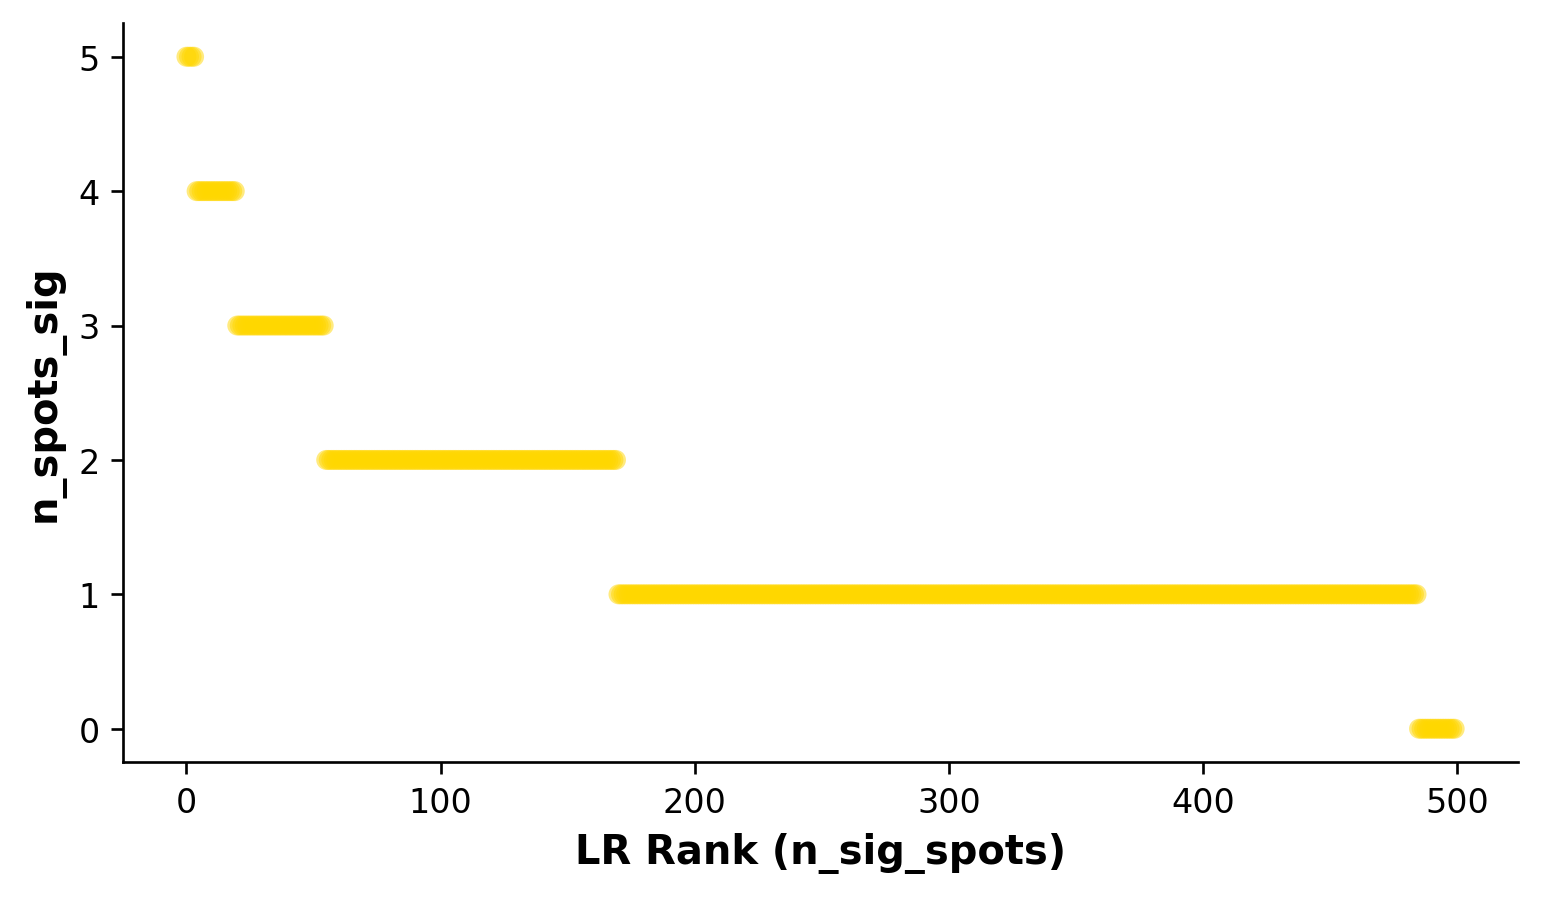

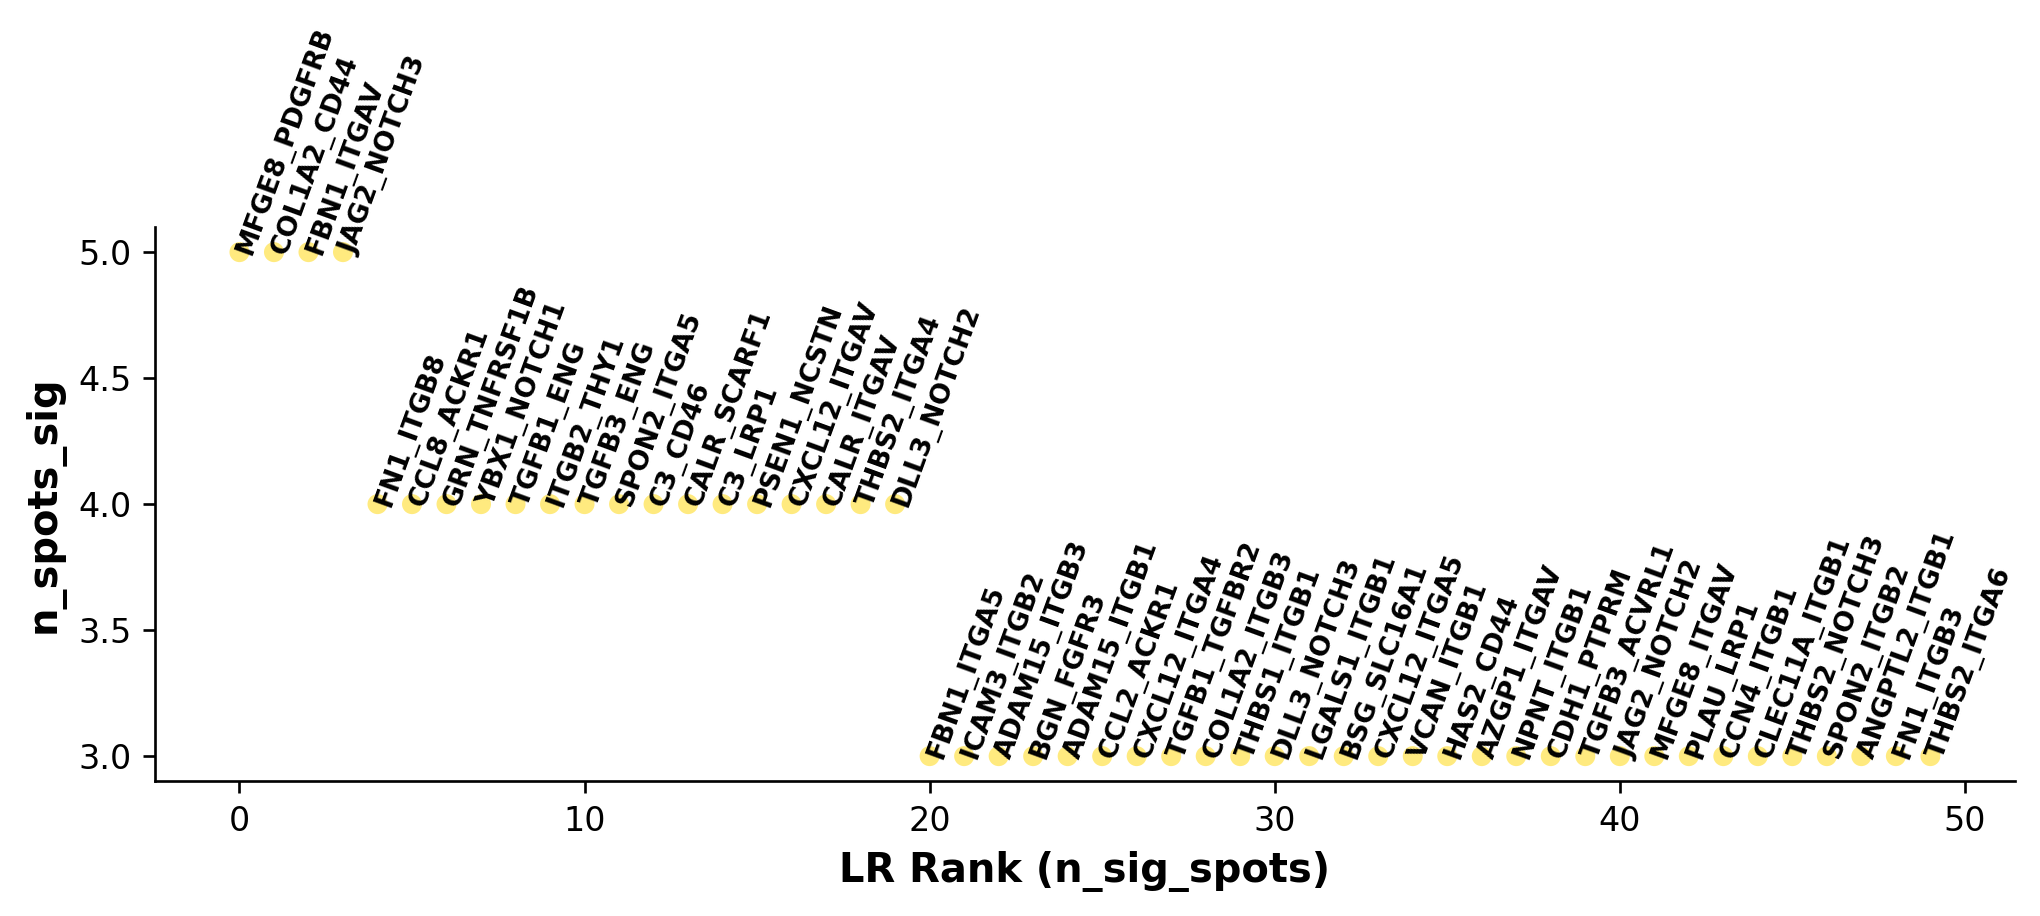

In [17]:
st.tl.cci.adj_pvals(data, correct_axis='spot',
                   pval_adj_cutoff=0.05, adj_method='fdr_bh')
# Showing the rankings of the LR from a global and local perspective.
# Ranking based on number of significant hotspots.
st.pl.lr_summary(data, n_top=500)
st.pl.lr_summary(data, n_top=50, figsize=(10,3))

In [18]:
st.pl.cluster_plot(adata_processed, use_label='cell_type')
st.pl.lr_chord_plot(adata_processed, 'cell_type', 'GPC3_IGF1R', figsize=(4,4))

NameError: name 'adata_processed' is not defined